In [1]:
import os
import pandas as pd
import numpy as np
from fish_helpers import *
import tqdm
import time
from scipy import sparse
import random
from ipypb import ipb
base = '/bigstore/binfo/mouse/Hippocampus/'

In [2]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      Metadata:  1.0 KiB
                      HybeData:  1.0 KiB
                       Counter:  1.0 KiB
                           _i2:  587.0 B
                   defaultdict:  400.0 B
                            _i:  253.0 B
                           _i1:  253.0 B
                           _oh:  240.0 B
                           Out:  240.0 B
                     spearmanr:  136.0 B


In [3]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    cell_set_accession = attributes['cell_set_accession']
    return c,h,a,b,children,cell_set_accession

C = []
H = []
A = []
B = []
cell_set_accessions = []
node_dict = {}

node = data
c,h,a,b,children,cell_set_accession = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
cell_set_accessions.append(cell_set_accession)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children,cell_set_accession = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        cell_set_accessions.append(cell_set_accession)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
cell_set_accessions_df = pd.DataFrame(cell_set_accessions,index=C)

"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in ipb(enumerate(cells),ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types)
binary_node_df = binary_node_df.T

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 [████████████████████████████████████████████████████████████] 290/290 [00:14<00:00, 0.05s/it]

In [2]:
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
metadata

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cluster_color,cluster_order,cluster_label,class_color,class_order,class_label,subclass_color,subclass_order,subclass_label,full_genotype_color,...,injection_method_label,injection_roi_color,injection_roi_order,injection_roi_label,propagation_type_color,propagation_type_order,propagation_type_label,subregion_color,subregion_order,subregion_label
sample_name,,,,,,,,,,,,,,,,,,,,,
LS-15546_S49_E1-50,#29B948,130,L2/3 IT Otof_6,#0078C3,2,Glutamatergic,#0BE652,19,L2/3 IT Otof,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S50_E1-50,#22D0B8,171,L4/5 IT_15,#0078C3,2,Glutamatergic,#00E5E5,23,L4/5 IT,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S51_E1-50,#21D238,129,L2/3 IT Otof_5,#0078C3,2,Glutamatergic,#0BE652,19,L2/3 IT Otof,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S52_E1-50,#60958B,177,L5 IT_9,#0078C3,2,Glutamatergic,#50B2AD,21,L5 IT,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S53_E1-50,#0CB1B1,165,L4/5 IT_9,#0078C3,2,Glutamatergic,#00E5E5,23,L4/5 IT,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S54_E1-50,#0CB1B1,165,L4/5 IT_9,#0078C3,2,Glutamatergic,#00E5E5,23,L4/5 IT,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S55_E1-50,#748F6F,179,L5 IT_11,#0078C3,2,Glutamatergic,#50B2AD,21,L5 IT,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S56_E1-50,#FF0000,302,Doublet_11,#000000,4,Exclude,#808080,50,Doublet,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN
LS-15546_S58_E1-50,#C8B323,141,L6 IT_4,#0078C3,2,Glutamatergic,#A19922,20,L6 IT,#CC473D,...,Pressure,#8B3DCC,26,SSs,#171799,3,retrograde,#FF7373,1,NaN


In [3]:
metadata.columns

Index(['cluster_color', 'cluster_order', 'cluster_label', 'class_color',
       'class_order', 'class_label', 'subclass_color', 'subclass_order',
       'subclass_label', 'full_genotype_color', 'full_genotype_order',
       'full_genotype_label', 'donor_sex_color', 'donor_sex_order',
       'donor_sex_label', 'region_color', 'region_order', 'region_label',
       'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label',
       'cell_type_accession_color', 'cell_type_accession_order',
       'cell_type_accession_label', 'cell_type_alias_color',
       'cell_type_alias_order', 'cell_type_alias_label',
       'cell_type_alt_alias_color', 'cell_type_alt_alias_order',
       'cell_type_alt_alias_label', 'cell_type_designation_color',
       'cell_type_designation_order', 'cell_type_designation_label',
       'external_donor_name_color', 'external_donor_name_order',
       'external_donor_name_label', 'facs_population_plan_color',
       'facs_population_plan_order', 'facs_popu

In [5]:
metadata.region_label.unique()

array(['MOs', 'VISp', 'MOp', 'PTLp', 'SSp', 'SSs', 'AUD', 'GU;VISC;AIp',
       'ACA', 'CLA', 'HIP', 'PL;ILA', 'ORB', 'CLA;EPd', 'SSs;GU',
       'SSs;GU;VISC', 'RSP', 'AI', 'TEa;PERI;ECT', 'ENTm', 'RSPv', 'ENTl',
       'PAR;POST;PRE', 'SUB;ProS', 'CA', 'VISpl;VISpor',
       'VISal;VISl;VISli', 'VISam;VISpm'], dtype=object)

In [7]:
metadata.cortical_layer_label.unique()

array(['All', 'L1', 'L1/2/3', 'L1/2/3/4', 'L2', 'L2/3', 'L2/3/4',
       'L2/3/5', 'L4', 'L4/5', 'L4/5/6', 'L5', 'L5/6', 'L6', 'L6b', nan],
      dtype=object)

In [50]:
"""
Loading Data from backup
"""
raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/raw_counts.npz'))
normalized_raw_counts_sparse = sparse.csr_matrix((10**6)*raw_counts_sparse/raw_counts_sparse.sum(0))
del raw_counts_sparse
# sparse.save_npz(os.path.join(base,'Allen/normalized_raw_counts.npz'),normalized_raw_counts_sparse)
# normalized_raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/normalized_raw_counts.npz'))
cells = np.array(pd.read_csv(os.path.join(base,'Allen/raw_cells.csv'),index_col=0)['0'])
genes = np.array(pd.read_csv(os.path.join(base,'Allen/raw_genes.csv'),index_col=0)['0'])
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
sample_cluster_probabilities = pd.read_csv(os.path.join(base,'sample_cluster_probabilities.csv'),index_col=0)
prob = sample_cluster_probabilities.loc[cells]
normalized_raw_counts = pd.DataFrame(normalized_raw_counts_sparse.A,index=genes,columns=cells).T
# raw_counts = raw_counts_sparse.A
# raw_counts = raw_counts.astype('float16')
# raw_counts = (10**6)*(raw_counts/np.sum(raw_counts,axis=0))
# raw_counts = pd.DataFrame(raw_counts,index=genes,columns=cells)
# raw_counts = raw_counts.astype('float16')
# raw_counts = raw_counts.T
# """
# Filter out lowly expressing genes
# """
# gene_thresh = 5
# cell_thresh = 100
# gene_filter = np.sum(1*(raw_counts>=gene_thresh),axis=1)>cell_thresh
# genes = genes[gene_filter]
# raw_counts = raw_counts[gene_filter,:]
# raw_counts_sparse = sparse.csr_matrix(raw_counts)
# sparse.save_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'),raw_counts_sparse)
# pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'))
# pd.DataFrame(genes).to_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'))

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
cell_type_averages = pd.DataFrame(index=genes)
column = list(prob.columns)[0]
for column in ipb(prob.columns):
    index = cell_set_accessions_df[cell_set_accessions_df[0]==column].index[0]
    column_prob = prob[prob[column]>0][column]
    averages = np.sum(np.multiply(normalized_raw_counts.loc[column_prob.index],np.array(column_prob)[:,None]),axis=0)/np.sum(column_prob)
    cell_type_averages[index] = pd.DataFrame(averages,index=genes,columns=[index])

 [████████████████████████████████████████████████████████████] 290/290 [03:42<00:00, 0.76s/it]

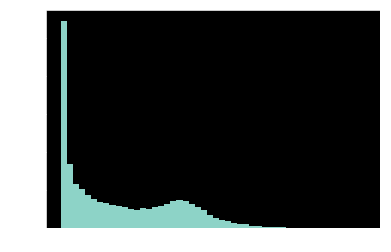

In [56]:
"""
Fiter genes
"""
plt.hist(np.log10(np.max(cell_type_averages,axis=1)+1),bins=50)
plt.show()

18322


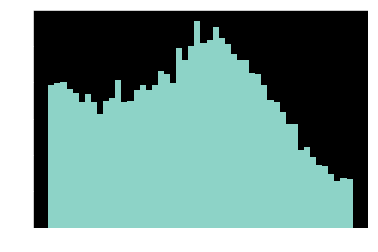

In [59]:
"""
Filter genes
"""
counts_max_thresh = 1000
counts_min_thresh = 10
max_averages = np.max(cell_type_averages,axis=1)
filtered_cell_type_averages = cell_type_averages[(max_averages<counts_max_thresh)&(max_averages>counts_min_thresh)]
print(len(filtered_cell_type_averages))
plt.hist(np.log10(np.max(filtered_cell_type_averages,axis=1)+1),bins=50)
plt.show()

In [50]:
cell_type_averages.to_csv(os.path.join(base,'Allen/normalized_cell_type_average_counts.csv.gz'),compression='gzip')

In [4]:
cell_type_averages = pd.read_csv(os.path.join(base,'Allen/normalized_cell_type_average_counts.csv.gz'),index_col=0)

In [66]:
counts_thresh=10
node_averages = filtered_cell_type_averages.copy()
for idx,row in ipb(linkage.sort_values('H').iterrows(),len(linkage)):
    A = row['A']
    B = row['B']
    if not (A=='None')&(B=='None'):
        node_averages[row['C']] = (node_averages[A]+node_averages[B])/2
filtered_node_averages = node_averages[np.max(node_averages,axis=1)>counts_thresh]

 [████████████████████████████████████████████████████████████] 579/579 [00:01<00:00, 0.00s/it]

In [67]:
"""
Walk down dendrogram chosing genes above threshold for sperability
"""
genes = np.array(filtered_node_averages.index)
seperability_df = pd.DataFrame(index=genes)
for idx,row in ipb(linkage.sort_values('H').iterrows(),len(linkage)):
    A = row['A']
    B = row['B']
    if not (A=='None')&(B=='None'):
        temp = (filtered_node_averages[A]-filtered_node_averages[B])/(np.sqrt(filtered_node_averages[A])+np.sqrt(filtered_node_averages[B]))
        seperability_df[row['A']] = temp
        seperability_df[row['B']] = -temp
seperability_df[seperability_df.isna()]=0

 [████████████████████████████████████████████████████████████] 579/579 [00:01<00:00, 0.00s/it]

average 0.006991903449802057
std 0.4349397979986978
107


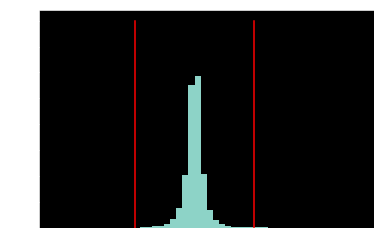

In [95]:
column = seperability_df.columns[0]
temp = seperability_df[column].sort_values(ascending=False)
avg = np.average(temp)
std = np.std(temp)
nstd = 5
min_thresh = -nstd*std
max_thresh = nstd*std
print('average',avg)
print('std',std)
print(len(temp[(temp>(max_thresh))|(temp<(min_thresh))]))
plt.hist(temp,bins=50)
plt.plot([max_thresh,max_thresh],[0,8000],c='r')
plt.plot([min_thresh,min_thresh],[0,8000],c='r')
plt.show()

In [94]:
node_genes = {}
good_genes = []
nstd = 5
for column in ipb(seperability_df.columns):
    temp = seperability_df[column].sort_values(ascending=False)
    avg = np.average(temp)
    std = np.std(temp)
    min_thresh = -nstd*std
    max_thresh = nstd*std
    g = list(temp[(temp>(max_thresh))|(temp<(min_thresh))].index)
    node_genes[column] = g
    good_genes.extend(g)
len(np.unique(good_genes))

 [████████████████████████████████████████████████████████████] 578/578 [00:05<00:00, 0.01s/it]

3100

In [70]:
for n,g in node_genes.items():
    print(n,len(g))

L4/5 IT_9 107
L4/5 IT_10 107
L6 CT_9 99
L6 CT_10 99
L4/5 IT_13 56
L4/5 IT_14 56
L5 IT_8 95
L5 IT_9 95
Sst_10 89
Sst_11 89
L4/5 IT_3 79
L4/5 IT_4 79
L2/3 IT Otof_5 86
L2/3 IT Otof_6 86
n177 86
L4/5 IT_15 86
L5 ET_6 98
L5 ET_7 98
L5 IT_4 97
L5 IT_5 97
Car3_3 87
Car3_4 87
L6b_8 81
L6b_9 81
L6 CT_5 92
L6 CT_6 92
L6b_6 90
L6b_7 90
Lamp5_2 95
Lamp5_3 95
L5 ET_13 69
L5 ET_14 69
Pvalb_7 89
Pvalb_8 89
Sst_26 89
Sst_27 89
L5 IT_10 73
L5 IT_11 73
L4 IT_4 96
n173 96
L2/3 IT Otof_2 60
L2/3 IT Otof_3 60
NP_1 79
NP_2 79
Sst_19 94
Sst_20 94
CA3sp_6 77
CA3sp_7 77
L4/5 IT_7 92
L4/5 IT_8 92
L4/5 IT_5 79
L4/5 IT_6 79
L2/3 IT Otof_4 76
n151 76
L2/3 IT Plch1_3 35
L2/3 IT Plch1_4 35
L6 IT_9 77
L6 IT_10 77
L6b_5 109
n39 109
L6 IT_2 85
L6 IT_3 85
L4/5 IT_11 101
L4/5 IT_12 101
Sst_9 102
n265 102
Lamp5 Lhx6_1 103
Lamp5 Lhx6_2 103
CA1sp_1 95
CA1sp_2 95
CA1sp_6 91
CA1sp_7 91
L2/3 IT Otof_9 59
L2/3 IT Otof_10 59
L5 ET_3 76
L5 ET_4 76
L6 CT_3 56
L6 CT_4 56
n59 85
L6 CT_7 85
L6 CT_15 56
L6 CT_16 56
L5 IT_7 89
n165 89

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


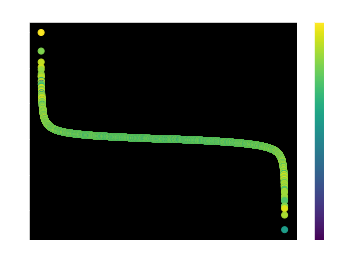

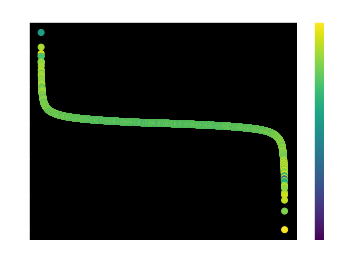

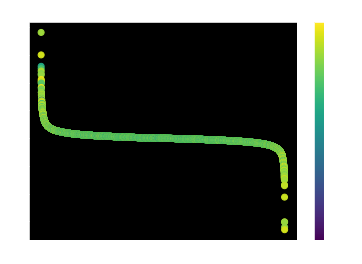

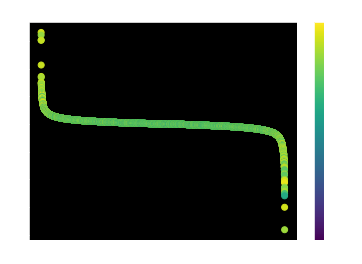

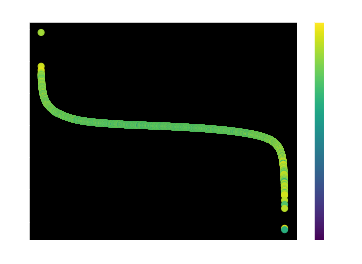

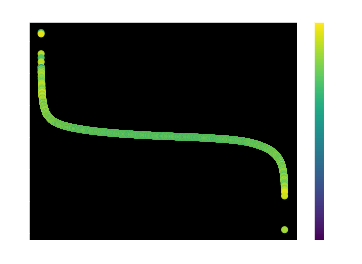

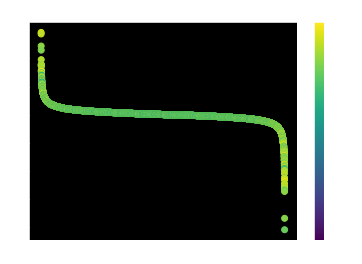

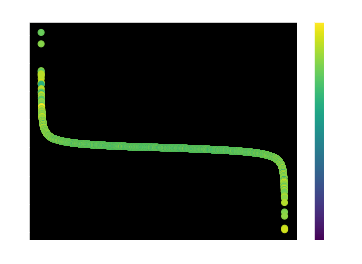

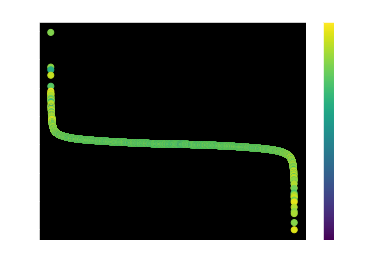

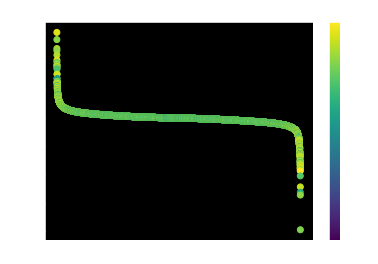

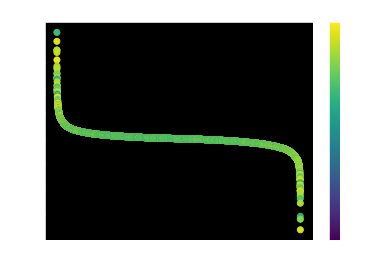

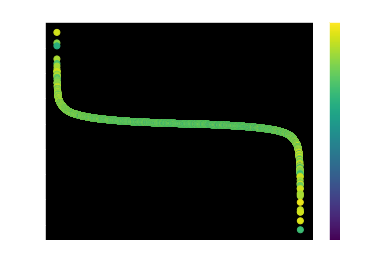

KeyboardInterrupt: 

In [71]:
for column in seperability_df.columns:
    temp = seperability_df[column].sort_values(ascending=False)
    plt.scatter(range(len(seperability_df)),temp,c=np.log10(seperability_df['n2'].loc[temp.index]+1))
    plt.title(column)
    plt.colorbar()
    plt.show()

L5 IT_8


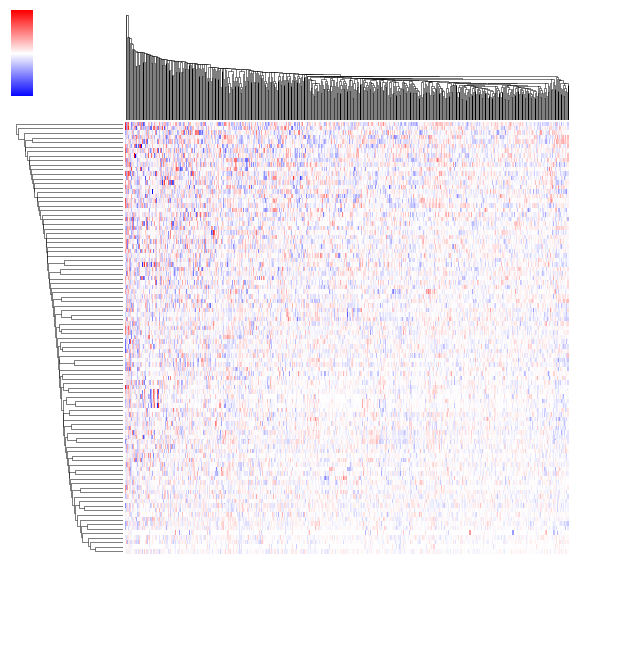

In [79]:
node = list(node_genes.keys())[6]
print(node)
temp = seperability_df.loc[np.unique(node_genes[node])]
# log_temp = np.log10(np.abs(temp)+1)
# log_temp[temp<0]=-log_temp[temp<0]
# sns.clustermap(log_temp,cmap='bwr',center=0)
sns.clustermap(temp,cmap='bwr',center=0)
plt.show()

In [81]:
normalized_raw_counts.shape

(74967, 45768)

In [87]:
normalized_raw_counts

,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,...,n-R5s134,n-R5s136,n-R5s138,n-R5s139,n-R5s141,n-R5s142,n-R5s143,n-R5s144,n-R5s146,n-R5s149
SM-GE669_S180_E1-50,0.000000,0.000000,156.232809,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SQ-80015_S33_E1-50,0.000000,0.000000,59.523272,31.608910,0.000000,2.463032,3.694548,0.0,71.838432,25.861835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE93C_S038_E1-50,0.000000,0.000000,0.000000,0.000000,0.000000,86.525444,0.000000,0.0,335.922310,66.166516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE8Z8_S370_E1-50,0.000000,0.000000,143.174760,108.615335,0.000000,13.165495,0.000000,0.0,21.393930,26.330990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE5TP_S167_E1-50,0.000000,0.000000,49.236160,98.472321,0.000000,0.000000,1.697799,0.0,42.444966,11.884590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE679_S037_E1-50,0.000000,0.000000,65.810012,59.060267,0.000000,6.749745,0.000000,0.0,167.056183,20.249234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-D9D91_S64_E1-50,0.000000,0.000000,0.420542,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.682168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-DAIFW_S61_E1-50,0.000000,0.000000,31.153659,67.824112,0.000000,0.000000,36.994970,0.0,41.862729,13.954243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SM-GE63V_S055_E1-50,0.000000,0.000000,119.902023,77.530631,0.000000,0.000000,0.000000,0.0,131.621770,67.613923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US-1250273_E2_S75,0.000000,0.000000,76.571506,58.671673,0.000000,0.000000,3.480523,0.0,131.265439,43.257929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
binary_seperable_filtered_normalized_counts = normalized_raw_counts[np.unique(good_genes)].T
binary_seperable_filtered_normalized_counts.shape

(3100, 74967)

In [91]:
binary_sparse = sparse.csr_matrix(binary_seperable_filtered_normalized_counts)
sparse.save_npz(os.path.join(base,'Allen/binary_seperable_filtered_normalized_counts.npz'),binary_sparse)
pd.DataFrame(list(binary_seperable_filtered_normalized_counts.index)).to_csv(os.path.join(base,'Allen/binary_seperable_filtered_normalized_genes.csv'))
pd.DataFrame(list(binary_seperable_filtered_normalized_counts.columns)).to_csv(os.path.join(base,'Allen/binary_seperable_filtered_normalized_cells.csv'))